In [1]:
import pandas as pd
from neo4j import GraphDatabase, basic_auth
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

In [2]:
# Importing cleaned dataset for exploration and analysis
npi_data = pd.read_pickle('data/cleaned_npi_taxonomy_names_cbsa_pickle.csv')

In [3]:
npi_data.head()

,from_npi,to_npi,patient_count,transaction_count,average_day_wait,from_specialty,CBSA,to_organization,from_provider_name,from_state
0,1033194220,1003000308,62,80,26.175,"Radiology, Diagnostic Radiology",12060.0,"BUCKHEAD EAR, NOSE AND THROAT","JACOBS, LOUIS",GA
1,1295734820,1003000308,46,52,49.462,Cardiovascular Disease,12060.0,"BUCKHEAD EAR, NOSE AND THROAT","ARNOLD, WILLIAM",GA
2,1295734820,1003000308,46,52,49.462,Cardiovascular Disease,12060.0,"BUCKHEAD EAR, NOSE AND THROAT","ARNOLD, WILLIAM",GA
3,1518973437,1003000308,44,51,33.843,Cardiovascular Disease,12060.0,"BUCKHEAD EAR, NOSE AND THROAT","COOK, ARTHUR",GA
4,1518973437,1003000308,44,51,33.843,Cardiovascular Disease,12060.0,"BUCKHEAD EAR, NOSE AND THROAT","COOK, ARTHUR",GA


In [4]:
# Filtering down to the Nashville CBSA region (34980) and counting the referred to providers
npi_data[npi_data.CBSA == 34980.0].to_organization.value_counts()

VANDERBILT MEDICAL GROUP                                2686
ASSOCIATED PATHOLOGISTS LLC DBA PATHGROUP                746
TRISTAR CENTENNIAL MEDICAL CENTER                        646
TENNESSEE OTHOPAEDIC ALLIANCE                            600
DBA THE FRIST CLINIC                                     433
                                                        ... 
REHAB. & HEALTHCARE CENTER OF CAPE CORAL                   1
PERSHING MEMORIAL HOSPITAL                                 1
VISION CONCEPTS                                            1
INTERNAL MEDICINE AND INFECTIOUS DISEASE ASSOC P. C.       1
NOVANT HEALTH KERNERSVILLE FAMILY MEDICINE                 1
Name: to_organization, Length: 2337, dtype: int64

In [5]:
# Filtering to the healthiest city (Miami, CBSA=33100) and getting top ten referral from specialties.
npi_data[npi_data.CBSA == 33100.0].from_specialty.value_counts().head(10)

Cardiovascular Disease             32120
Internal Medicine                  22895
Radiology, Diagnostic Radiology    19144
Family Medicine                    13246
Nephrology                         12916
Pulmonary Disease                  10250
Emergency Medicine                  8732
Gastroenterology                    8174
Infectious Disease                  7518
Hematology & Oncology               6272
Name: from_specialty, dtype: int64

In [6]:
# Unfiltered top ten referral from specialties for all locations for comparison
npi_data.from_specialty.value_counts().head(10)

Internal Medicine                  1033134
Radiology, Diagnostic Radiology     904844
Cardiovascular Disease              868642
Family Medicine                     767948
Nephrology                          510550
Emergency Medicine                  441973
Pulmonary Disease                   350556
Orthopedic Surgery                  324121
Hematology & Oncology               298700
Gastroenterology                    288860
Name: from_specialty, dtype: int64

In [7]:
# Creating lists of the top five and bottom five healthiest states, according to 2019 report by United Health Foundation
top_five_states = ['VT', 'MA', 'HI', 'CT', 'UT']
bottom_five_states = ['OK', 'AL', 'AR', 'LA', 'MS']

In [8]:
# A look at which specialties in the 5 healthiest states had the highest total of transaction referrals overall
npi_data[npi_data.from_state.isin(top_five_states)].groupby('from_specialty').transaction_count.sum().sort_values(ascending=False)

from_specialty
Cardiovascular Disease                                    17783346
Internal Medicine                                         16407423
Radiology, Diagnostic Radiology                           15023340
Family Medicine                                            5482440
Emergency Medicine                                         5235722
                                                            ...   
Pediatrics, Hospice and Palliative Medicine                    117
 Psychiatry & Neurology, Hospice & Palliative Medicine          81
Pediatrics, Pediatric Critical Care Medicine                    63
Urology, Pediatric Urology                                      63
Pediatrics, Pediatric Emergency Medicine                        54
Name: transaction_count, Length: 159, dtype: int64

In [9]:
# A look at which specialties in the 5 least healthy states had the highest total of transaction referrals overall
npi_data[npi_data.from_state.isin(bottom_five_states)].groupby('from_specialty').transaction_count.sum().sort_values(ascending=False)

from_specialty
Radiology, Diagnostic Radiology             23986788
Family Medicine                             19393768
Cardiovascular Disease                      16462004
Internal Medicine                           16077883
Nephrology                                   8307910
                                              ...   
Pediatrics, Pediatric Emergency Medicine         489
Family Medicine, Adolescent Medicine             413
Pediatrics, Pediatric Cardiology                 326
Pediatrics, Pediatric Pulmonology                253
Pediatrics, Neonatal-Perinatal Medicine           58
Name: transaction_count, Length: 155, dtype: int64

In [10]:
# Creating a dataset of the transaction referrals by specialty for the 5 most healthy states
top_five_rank = npi_data[npi_data.from_state.isin(top_five_states)].groupby('from_specialty').transaction_count.sum().sort_values(ascending=False)
top_five_rank = pd.DataFrame(top_five_rank).reset_index()
top_five_rank = top_five_rank.rename(columns = {'from_specialty':'Specialty', 'transaction_count':'top_five_count'})

In [11]:
# Creating a dataset of the transacttion referrals by specialty for the 5 least healthy states
bottom_five_rank = npi_data[npi_data.from_state.isin(bottom_five_states)].groupby('from_specialty').transaction_count.sum().sort_values(ascending=False)
bottom_five_rank = pd.DataFrame(bottom_five_rank).reset_index()
bottom_five_rank = bottom_five_rank.rename(columns = {'from_specialty':'Specialty', 'transaction_count':'bottom_five_count'})

In [12]:
# Creating a specialty:color dictionary for creating graphs with consistent color schemes
specialty_keys = set(list(bottom_five_rank.Specialty.head(10))+list(top_five_rank.Specialty.head(10)))

color_list = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'navy', 'lime', 'plum']

specialty_colors = dict(zip(specialty_keys, color_list))

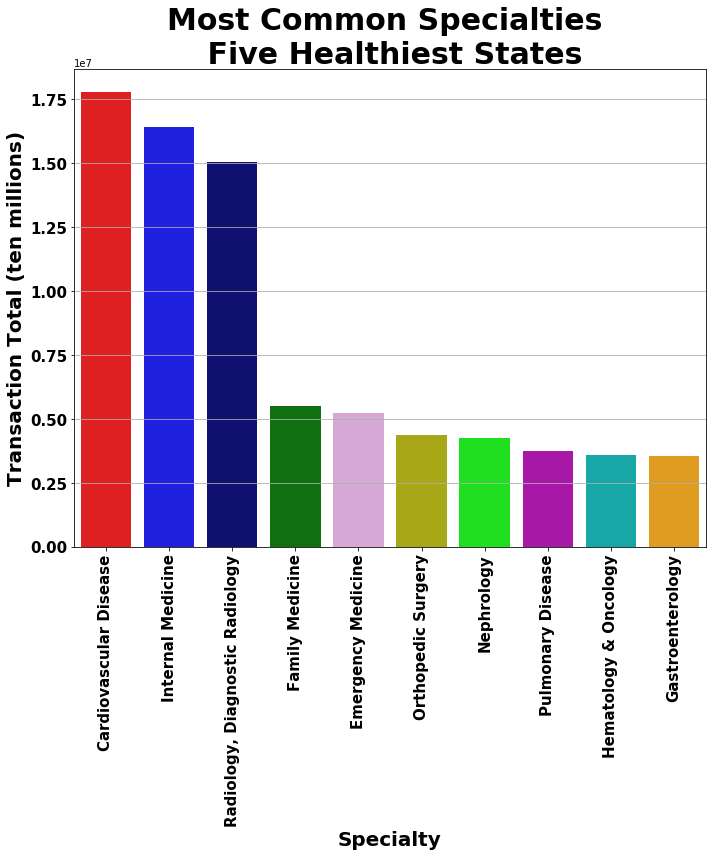

In [13]:
# Bar graph showing the top 10 specialties by referral count in the healthiest states
fig = plt.subplots(figsize=(10,12))
fig = sns.barplot(data=top_five_rank.head(10), x='Specialty', y='top_five_count', palette = specialty_colors)
fig.set_xlabel('Specialty', fontsize=20, fontweight='bold')
fig.set_ylabel('Transaction Total (ten millions)', fontsize=20, fontweight='bold')
fig.set_title('Most Common Specialties \n Five Healthiest States', fontsize=30, fontweight='bold')
plt.xticks(rotation = 90, fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.grid(which='major', axis='y')
plt.tight_layout()
plt.savefig('figures/most_healthy_specialties.png', dpi = 250)

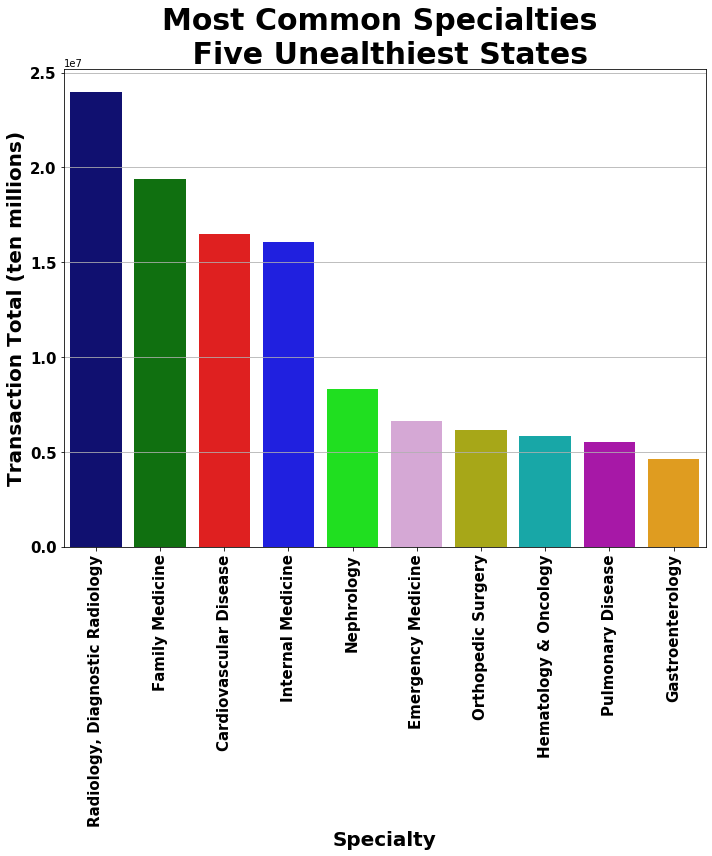

In [14]:
# Bar graph showing the top 10 specialties by referral count in the least healthy states
fig = plt.subplots(figsize=(10,12))
fig = sns.barplot(data=bottom_five_rank.head(10), x='Specialty', y='bottom_five_count', palette = specialty_colors)
fig.set_xlabel('Specialty', fontsize=20, fontweight='bold')
fig.set_ylabel('Transaction Total (ten millions)', fontsize=20, fontweight='bold')
fig.set_title('Most Common Specialties \n Five Unealthiest States', fontsize=30, fontweight='bold')
plt.xticks(rotation = 90, fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.grid(which='major', axis='y')
plt.tight_layout()
plt.savefig('figures/least_healthy_specialties.png', dpi = 250)

In [15]:
# When we compare the specialty referral counts, we see the top ten remain the same for both most and least healthy
# states, but the 1 and 2 positions are switched with the 3 and 4 positions for each set.

In [16]:
# Next I wanted to look at the overall difference in specialty referrals from one group to the other. To do this I
# standardized the values by looking at overall percentage of referrals rather than overall transaction count. The
# change in percentage of referrals was then calculated and used to find the specialties with the largest change
# from healthy states to unhealthy states.

In [17]:
# Creating a new dataset and merging the most and least healthy state counts by specialty
specialty_change = top_five_rank.merge(bottom_five_rank, on='Specialty')
# Calculating the percentage of overall referrals for each specialty and creating a column for these values
specialty_change['top_five_pct'] = (specialty_change.top_five_count)/(specialty_change.top_five_count.sum())*100
specialty_change['bottom_five_pct'] = (specialty_change.bottom_five_count)/(specialty_change.bottom_five_count.sum())*100
# Creating a column with the change in referral percentage from group to group
specialty_change['change_in_percentage'] = specialty_change.top_five_pct - specialty_change.bottom_five_pct
# Creating a column of absolute value to use for sorting and selecting specialties with the largest change, pos and neg
specialty_change['absolute_val_change'] = specialty_change.change_in_percentage.abs()

In [18]:
# Selecting for the ten specialties with the greatest change in percentage of referrals
specialty_change = specialty_change.sort_values('absolute_val_change', ascending=False).head(10)

In [19]:
# Re-sorting the remaining data by change in percentage to show positive and negative on opposite ends of the data
specialty_change = specialty_change.sort_values('change_in_percentage', ascending=False)

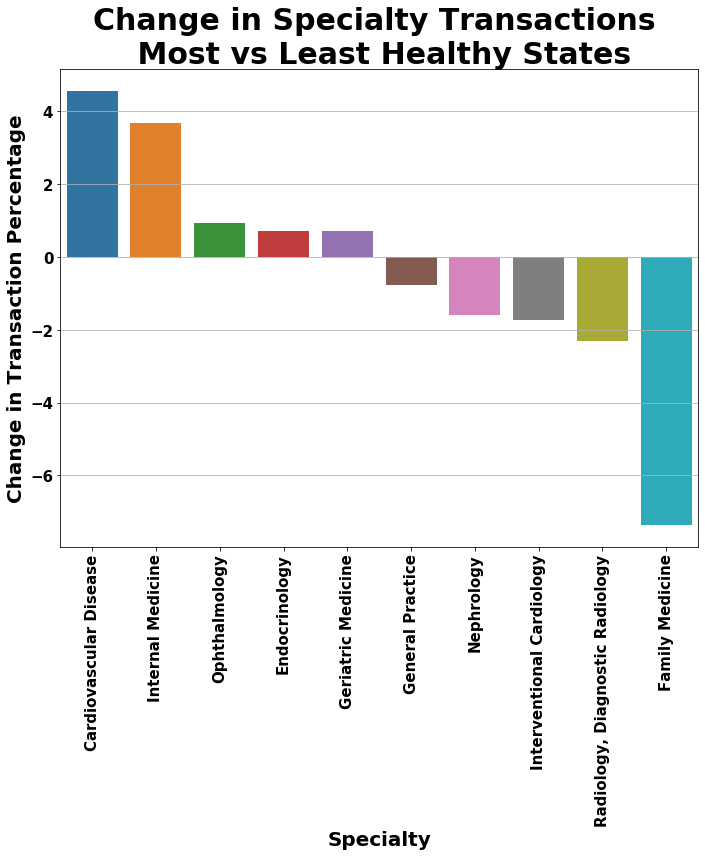

In [20]:
# Creating a bar graph to show the change in referral percentage. Positive values (eg. Cardiovasular Disease) show a
# higher representation in the most healthy states and negative values (Family Medicine) show a higher representation
# in the least healthy states.
fig = plt.subplots(figsize=(10,12))
fig = sns.barplot(data=specialty_change, x='Specialty', y='change_in_percentage')
fig.set_xlabel('Specialty', fontsize=20, fontweight='bold')
fig.set_ylabel('Change in Transaction Percentage', fontsize=20, fontweight='bold')
fig.set_title('Change in Specialty Transactions \n Most vs Least Healthy States', fontsize=30, fontweight='bold')
plt.xticks(rotation = 90, fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.grid(which='major', axis='y')
plt.tight_layout()
plt.savefig('figures/pct_change_healhty_un.png', dpi = 250)

# Working to put in a comparison of urban/rural regions in neo4j

In [21]:
# The hope of this section is to explore differences in referral relationships from urban to rural locations. Do urban
# locations have a tendency to consolidate referrals to a few well-known organizations while the spread and lack of 
# big name organizations cause rural communities to have a better diversity of organizations referred to? Or is it the
# opposite of this?
# This section is still a work in progress using both Neo4j as well as networkx/graphviz to explore relational graphing

In [22]:
# Filter down the cleaned hop_npi data to a large urban area (NYC, CBSA = 35620)
nyc_referrals = pd.read_pickle('data/cleaned_npi_taxonomy_names_cbsa_pickle.csv')
nyc_referrals = nyc_referrals[nyc_referrals.CBSA == 35620.0]

In [23]:
# Choosing the columns that will be focused on, referring specialty, referral count, and organization referred to
nyc_referrals = nyc_referrals[['from_specialty','transaction_count','to_organization']]

In [24]:
# Grouping by and counting the referrals from each specialty to allow us to explore the referral counts and if some
# specialties are more prone to diverse/concentrated referral patterns
nyc_referrals = nyc_referrals.groupby(['from_specialty','to_organization']).transaction_count.sum()
nyc_referrals = pd.DataFrame(nyc_referrals)
nyc_referrals = nyc_referrals.reset_index()
nyc_referrals = nyc_referrals.rename(columns = {'from_specialty':'Specialty', 'transaction_count':'Referrals',
                                               'to_organization':'Organization'})

In [25]:
# Filtering down a list of the top 3 Specialties referring in the NYC CBSA
# This is done to filter the data down to a more manageable size before loading it into a relational graph
nyc_top_specialties = nyc_referrals.groupby('Specialty').Referrals.sum().sort_values(ascending=False).head(3)
nyc_top_specialties = pd.DataFrame(nyc_top_specialties).reset_index()
nyc_top_specialties = nyc_top_specialties.Specialty.tolist()

In [26]:
# Filtering down a list of the top 50 Organizations referred to in the NYC CBSA
nyc_top_organizations = nyc_referrals.groupby('Organization').Referrals.sum().sort_values(ascending=False).head(50)
nyc_top_organizations = pd.DataFrame(nyc_top_organizations).reset_index()
nyc_top_organizations = nyc_top_organizations.Organization.tolist()

In [27]:
# Using the filtered top Specialty and Organization lists to filter down the total NYC Referral dataset
nyc_referrals = nyc_referrals[nyc_referrals.Specialty.isin(nyc_top_specialties)]
nyc_referrals = nyc_referrals[nyc_referrals.Organization.isin(nyc_top_organizations)]

In [28]:
nyc_referrals.shape

(150, 3)

In [29]:
#pip install neo4j-driver

In [ ]:
# Importing the nyc_referral data into Neo4j for visualization
password = getpass.getpass()
driver = GraphDatabase.driver("bolt://localhost", auth=basic_auth("neo4j", password))
session = driver.session()

In [ ]:
insert_query = '''
UNWIND {pairs} as pair
MERGE (p1:Specialty {npi:pair[0]})
MERGE (p2:Organization {npi:pair[1]})
MERGE (p1)-[:REFERRED_TO {referrals:pair[2]}]->(p2);
'''

data = nyc_referrals.values.tolist()

session.run(insert_query, parameters={"pairs": data})

In [ ]:
# Filter down the cleaned hop_npi data to a rural area (Montana, state=MT)
montana_referrals = pd.read_pickle('data/cleaned_npi_taxonomy_names_cbsa_pickle.csv')
montana_referrals = montana_referrals[montana_referrals.from_state == 'MT']

In [ ]:
montana_referrals.shape

In [ ]:
# Performing the same group by on specialty and counting total referrals for the state of Montana
montana_referrals = montana_referrals.groupby(['from_specialty','to_organization']).transaction_count.sum()
montana_referrals = pd.DataFrame(montana_referrals)
montana_referrals = montana_referrals.reset_index()
montana_referrals = montana_referrals.rename(columns = {'from_specialty':'Specialty', 'transaction_count':'Referrals',
                                               'to_organization':'Organization'})

In [ ]:
# Filtering down a list of the top 50 Specialties referring in Montana dataset
montana_top_specialties = montana_referrals.groupby('Specialty').Referrals.sum().sort_values(ascending=False).head(50)
montana_top_specialties = pd.DataFrame(montana_top_specialties).reset_index()
montana_top_specialties = montana_top_specialties.Specialty.tolist()

In [ ]:
# Let's try using networkx for graphing

In [ ]:
G = nx.from_pandas_edgelist(nyc_referrals, source='Specialty', target='Organization', \
    create_using=nx.DiGraph)

In [ ]:
plt.figure(figsize=(15,10))
nx.draw(G, 
        pos = nx.nx_agraph.graphviz_layout(G, prog='fdp'), \
    #node_size=1200, 
        #node_color=colors,
        linewidths=0.25, \
    font_size=10, font_weight='bold', with_labels=False)
plt.show()
#plt.savefig('figures/starting_graph.png', dpi = 250)